In [3]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch
from torch import nn 
import torch.nn.functional as F

import os
import pandas as pd 
import numpy as np
import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

path_work = "/media/concha-eloko/Linux/depolymerase_building"

esm2_model_path = f"{path_work}/esm2_t12_35M_UR50D-finetuned-depolymerase.labels_4/checkpoint-6015"
DpoDetection_path = f"{path_work}/DepoDetection.T12.4Labels.1908.model"

tokenizer = AutoTokenizer.from_pretrained(esm2_model_path)
esm2_finetuned = AutoModelForTokenClassification.from_pretrained(esm2_model_path)

In [4]:
# *****************************************************************************
# Load the Dataframes :
path_work = "/media/concha-eloko/Linux/PPT_clean"
#path_work = "/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023"

    # Open the DF
DF_info = pd.read_csv(f"{path_work}/TropiGATv2.final_df.tsv", sep = "\t" ,  header = 0)


In [5]:
class Dpo_classifier(nn.Module):
    def __init__(self, pretrained_model):
        super(Dpo_classifier, self).__init__()
        self.max_length = 1024
        self.pretrained_model = pretrained_model
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, stride=1)  # Convolutional layer
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=1)  # Convolutional layer
        self.fc1 = nn.Linear(128 * (self.max_length - 2 * (5 - 1)), 32)  # calculate the output shape after 2 conv layers
        self.classifier = nn.Linear(32, 1)  # Binary classification

    def make_prediction(self, fasta_txt):
        input_ids = tokenizer.encode(fasta_txt, truncation=True, return_tensors='pt')
        with torch.no_grad():
            outputs = self.pretrained_model(input_ids)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            token_probs, token_ids = torch.max(probs, dim=-1)            
            tokens = token_ids.view(1, -1) # ensure 2D shape
            return tokens

    def pad_or_truncate(self, tokens):
        if tokens.size(1) < self.max_length:
            tokens = F.pad(tokens, (0, self.max_length - tokens.size(1)))
        elif tokens.size(1) > self.max_length:
            tokens = tokens[:, :self.max_length]
        return tokens

    def forward(self, sequences):
        batch_size = len(sequences)
        tokens_batch = []
        for seq in sequences:
            tokens = self.make_prediction(seq)
            tokens = self.pad_or_truncate(tokens)
            tokens_batch.append(tokens)
        
        outputs = torch.cat(tokens_batch).view(batch_size, 1, self.max_length)  # ensure 3D shape
        outputs = outputs.float()  # Convert to float
        
        out = F.relu(self.conv1(outputs))
        out = F.relu(self.conv2(out))
        out = out.view(batch_size, -1)  # Flatten the tensor
        out = F.relu(self.fc1(out))
        out = self.classifier(out)
        return out, outputs

In [11]:
model_classifier = Dpo_classifier(esm2_finetuned) # Create an instance of Dpo_classifier
model_classifier.load_state_dict(torch.load(DpoDetection_path), strict = False) # Load the saved weights ; weird Error with some of the keys 
model_classifier.eval() # Set the model to evaluation mode for inference


Dpo_classifier(
  (pretrained_model): EsmForTokenClassification(
    (esm): EsmModel(
      (embeddings): EsmEmbeddings(
        (word_embeddings): Embedding(33, 480, padding_idx=1)
        (dropout): Dropout(p=0.0, inplace=False)
        (position_embeddings): Embedding(1026, 480, padding_idx=1)
      )
      (encoder): EsmEncoder(
        (layer): ModuleList(
          (0-11): 12 x EsmLayer(
            (attention): EsmAttention(
              (self): EsmSelfAttention(
                (query): Linear(in_features=480, out_features=480, bias=True)
                (key): Linear(in_features=480, out_features=480, bias=True)
                (value): Linear(in_features=480, out_features=480, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (rotary_embeddings): RotaryEmbedding()
              )
              (output): EsmSelfOutput(
                (dense): Linear(in_features=480, out_features=480, bias=True)
                (dropout): Dropout(p=0.0, inpla

In [12]:
def predict_sequence(model, sequence):
    model.eval()
    with torch.no_grad():
        sequence = [sequence]  # Wrap the sequence in a list to match the model's input format
        outputs, sequence_outputs = model(sequence)
        probas = torch.sigmoid(outputs)  # Apply sigmoid activation for binary classification
        predictions = (probas > 0.5).float()  # Convert probabilities to binary predictions
        sequence_outputs_list = sequence_outputs.cpu().numpy().tolist()[0][0]
        prob_predicted = probas[0].item()
        return (predictions.item(), prob_predicted), sequence_outputs_list


def plot_token(tokens) :
    tokens = np.array(tokens)  # convert your list to numpy array for convenience
    plt.figure(figsize=(10,6))
    for i in range(len(tokens) - 1):
        if tokens[i] == 0:
            color = 'black'
        elif tokens[i] == 1:
            color = 'blue'
        elif tokens[i] == 2:
            color = 'red'
        else :
            color = 'green'
        plt.plot([i, i+1], [tokens[i], tokens[i+1]], color=color, marker='o')
    plt.xlabel('Token')
    plt.ylabel('Label')
    plt.title('Label for each token')
    plt.xticks(rotation='vertical')
    plt.yticks(np.arange(2), ['0', '1'])  
    plt.grid(True)
    plt.show()

In [10]:
DF_info_seek_TP = DF_info[DF_info["Dataset"] == "anubis_return"]
DF_info_seek_TP = DF_info_seek_TP.drop_duplicates(subset = "index" , keep = "first")


DF_info_seek_TP

,Phage,Protein_name,KL_type_LCA,Infected_ancestor,index,Dataset,seq,domain_seq,1,2,...,1272,1273,1274,1275,1276,1277,1278,1279,1280,prophage_id
17717,GCF_019336255.1__phage21,GCF_019336255.1__phage21__9,KL55|KL30|KL10,n51875187,anubis_return__5,anubis_return,MSYADWRVYQEATAEVFRRLGCNALVDYRAKGVRATHDIDVYATFL...,QAATSEASLILDSSDDGAPIYKFPSRSEPHDILLHNNFLITANWAG...,0.033236,0.007135,...,0.114908,-0.001712,-0.009527,-0.018942,0.064196,0.126328,-0.045083,-0.091659,0.035500,prophage_4208
17735,GCF_003334885.1__phage12,GCF_003334885.1__phage12__965,KL1,n1616,anubis_return__22,anubis_return,MRTISVRSVLLASTITISTVVTAYADSQWAAATTTFPGSIRAGSRE...,QVMLKLSKVVPPKNTEAFRLQTIPVGERAYQSAVSADGKLFVTSAR...,0.004311,-0.029432,...,0.024236,-0.036068,-0.070056,-0.082258,0.024811,0.099337,-0.098169,-0.064984,0.100955,prophage_374
17862,GCF_003036765.1__phage13,GCF_003036765.1__phage13__45,KL64,n25962596,anubis_return__45,anubis_return,MLKHSLAIATCLAFSSSVMGNEANLLYTNTMQFPYKHNADGYMVFD...,AFSSSVMGNEANLLYTNTMQFPYKHNADGYMVFDIHGKLVVPPEGH...,0.060544,0.042186,...,0.048438,-0.018707,0.009098,-0.000607,-0.017053,0.075963,-0.057643,-0.051022,-0.068246,prophage_313
18101,GCF_002970035.2__phage9,GCF_002970035.2__phage9__32,KL106,n32033203,anubis_return__53,anubis_return,MASIKELPRWEDEVYQIARGDKVEGGVGGIANMQAKTLAERTRYLK...,LLDPSAPEPMRMFNIKGKPRIELTAEELATFNATYSKYLKKGSQYL...,0.020271,0.077943,...,-0.019126,0.039506,0.068645,0.022851,0.172154,0.104167,-0.081774,0.036112,-0.053186,prophage_12
18471,GCF_900501665.1__phage4,GCF_900501665.1__phage4__148,KL25,n16501650,anubis_return__84,anubis_return,MYHLDNTSGVPEMPEPKEQQSISPRWFGESQEQGGISWPGADWFNT...,SIIGCVANANKRNVALLSGANNNTFNGLRCEWAEGDNFYAYNAVEN...,-0.009507,0.052764,...,0.001617,0.137578,0.025295,0.024155,0.052277,-0.003454,-0.067554,0.036250,0.074569,prophage_2115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20134,GCF_002248635.1__phage4,GCF_002248635.1__phage4__44,KL102,n320,anubis_return__4264,anubis_return,MVSLKGMGSTFRDCTALISLPSGLLDGCINLTSLTLTFSGCTSLAL...,MVSLKGMGSTFRDCTALISLPSGLLDGCINLTSLTLTFSGCTSLAL...,-0.000585,-0.087093,...,0.036749,0.048489,0.020484,0.023950,-0.048109,0.134457,-0.101326,0.088485,0.037368,prophage_3054
20135,GCF_001905235.1__phage21,GCF_001905235.1__phage21__0,KL107,n35403540,anubis_return__4272,anubis_return,MLKHSLAIATCLAFSSSVMGNEANLLYTNTMQFPYKHNADGYMVFD...,VMGNEANLLYTNTMQFPYKHNADGYMVFDIHGKLVVPPEGHFDTLN...,0.076721,0.027635,...,0.042391,-0.004292,-0.004047,-0.011631,-0.026469,0.070159,-0.077212,-0.077950,-0.034630,prophage_313
20136,GCF_004312845.1__phage3,GCF_004312845.1__phage3__38,KL9,GCF_004312845.1,anubis_return__4275,anubis_return,MAILITGKSMTRLPESSSWEEEIELITRSERVAGGLDGPANRPLKS...,DAVIRRDLASDKGTSGVGKLGDKPLVAISYYKSKGQSDQDAVQAAF...,0.032196,0.048856,...,-0.016331,0.084711,0.056063,0.001793,0.073958,0.090169,-0.060105,0.023726,0.086452,prophage_12656
20137,GCF_900172635.1__phage2,GCF_900172635.1__phage2__1608,KL124,GCF_900172635.1,anubis_return__4287,anubis_return,MADLSISVISDQASESNQAGWWHPLDSFQGVEYYGLCKEYGTAGYH...,MADLSISVISDQASESNQAGWWHPLDSFQGVEYYGLCKEYGTAGYH...,-0.011089,-0.005328,...,0.034656,0.046130,0.012586,-0.021702,-0.023386,0.105700,-0.099147,-0.057367,0.091427,prophage_12780


43it [00:18,  2.42it/s]

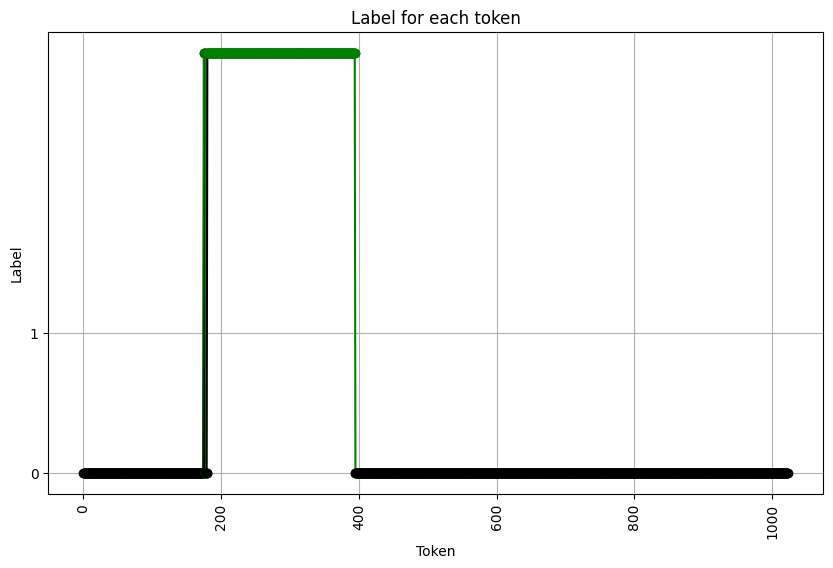

137it [01:09,  1.89it/s]

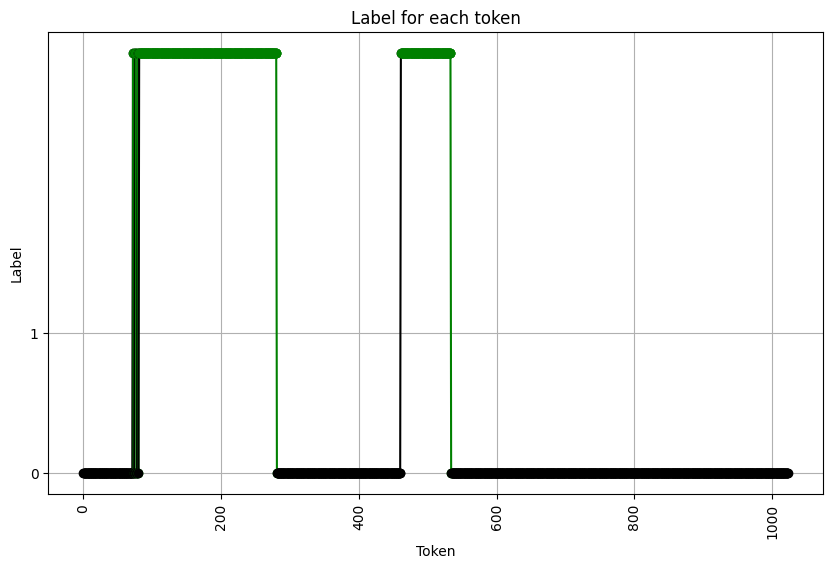

174it [01:31,  2.20it/s]

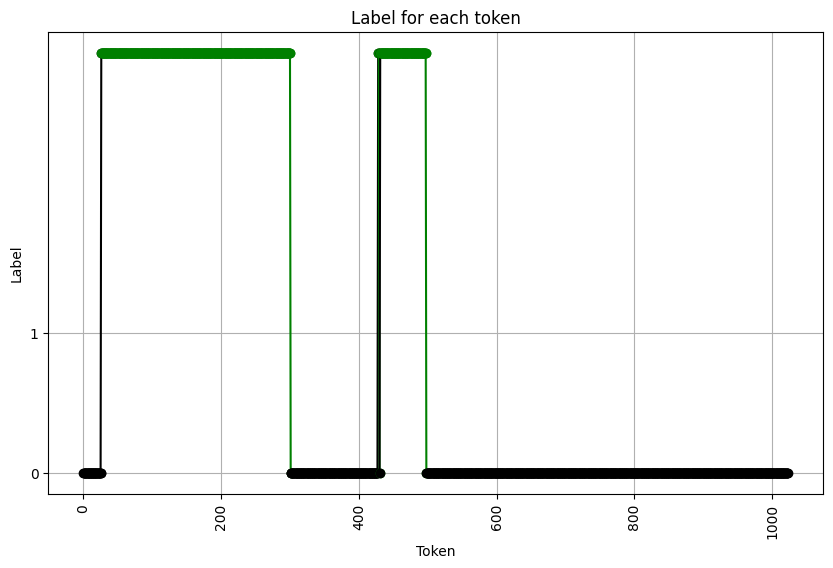

246it [02:03,  3.16it/s]

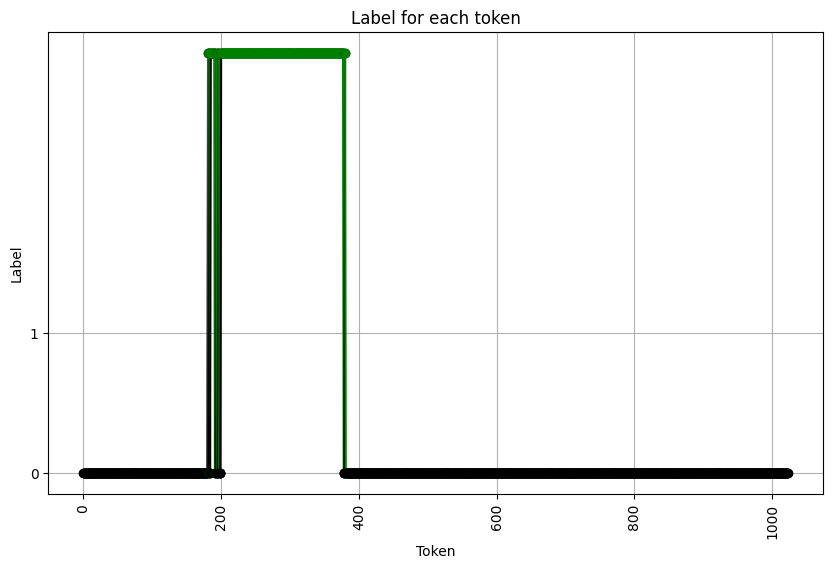

300it [02:34,  3.31it/s]

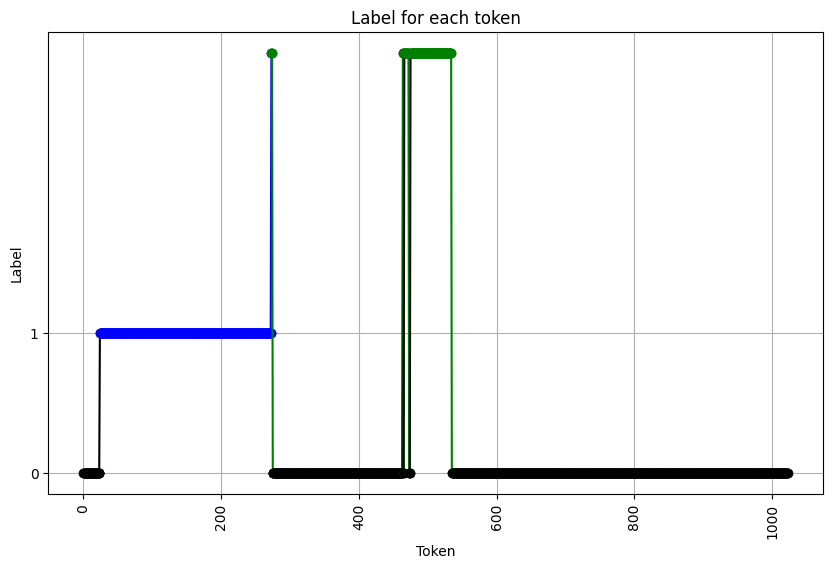

314it [02:41,  2.72it/s]

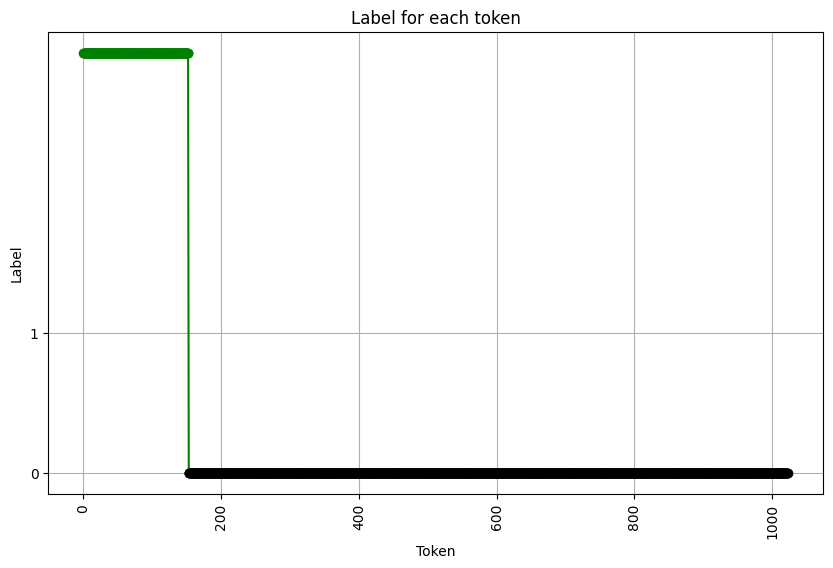

371it [03:11,  2.28it/s]

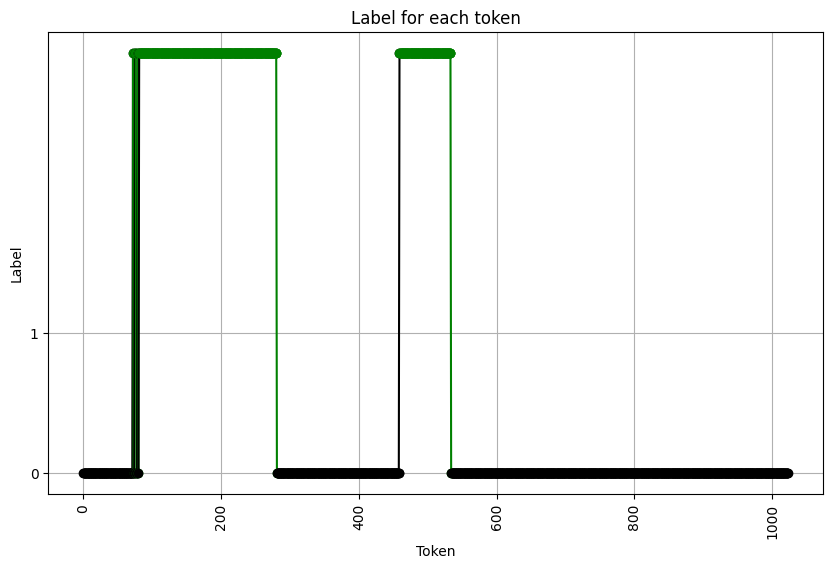

430it [03:41,  2.46it/s]

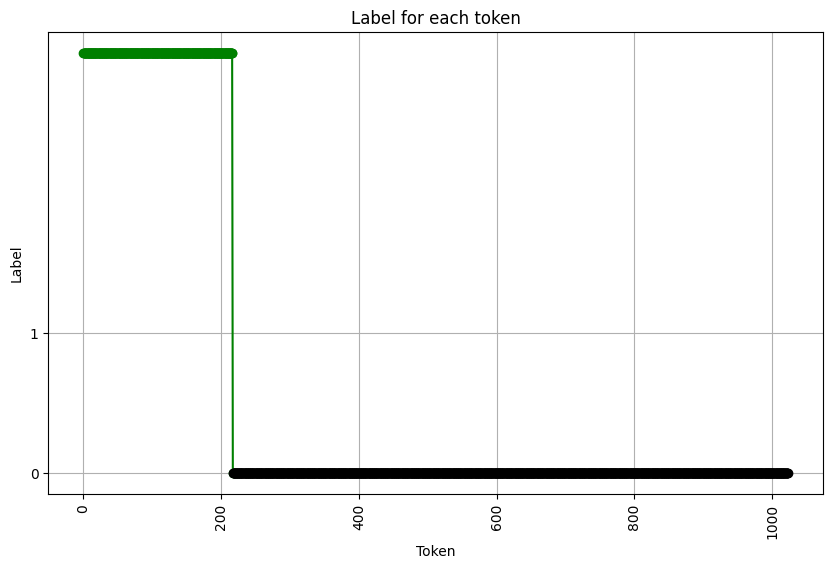

475it [04:03,  1.49it/s]

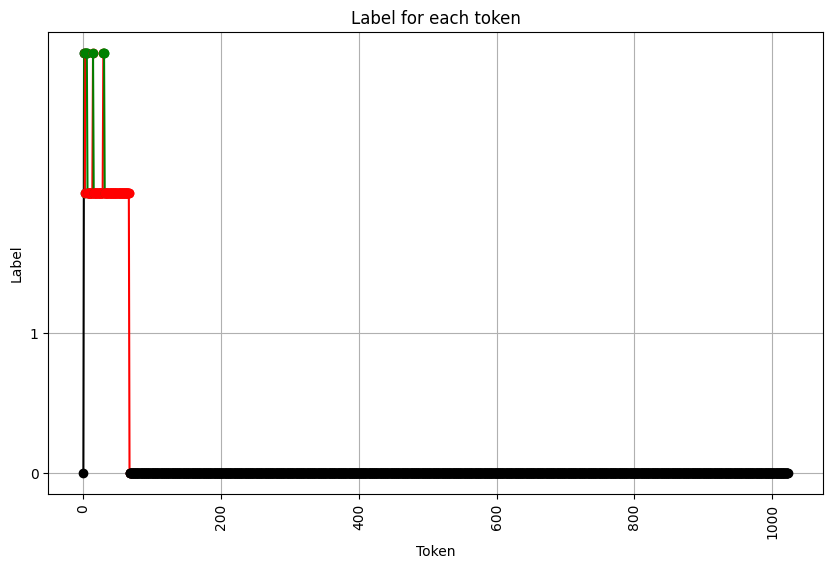

485it [04:10,  2.16it/s]

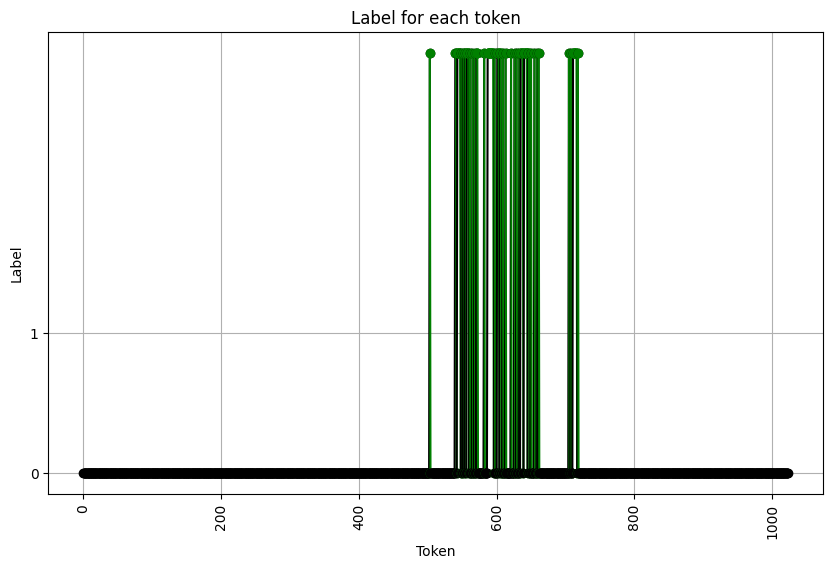

502it [04:20,  2.63it/s]

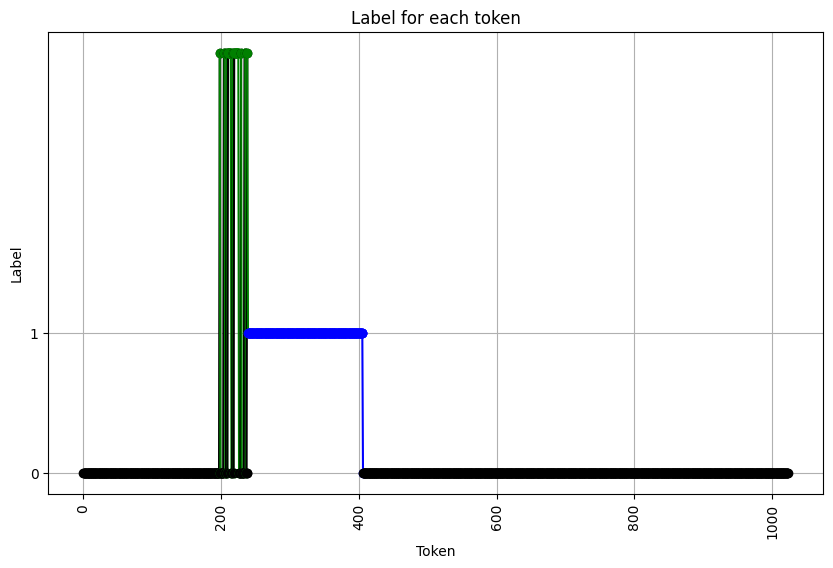

521it [04:30,  1.59it/s]

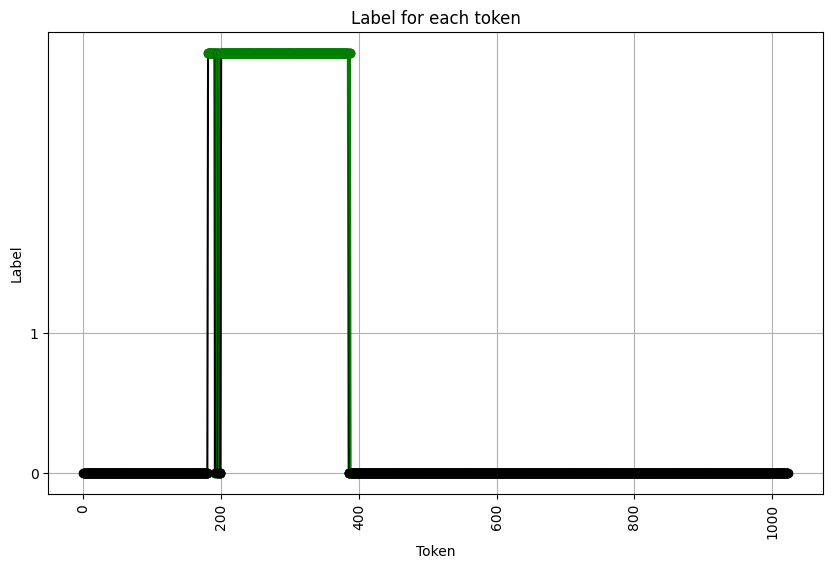

549it [04:46,  1.85it/s]

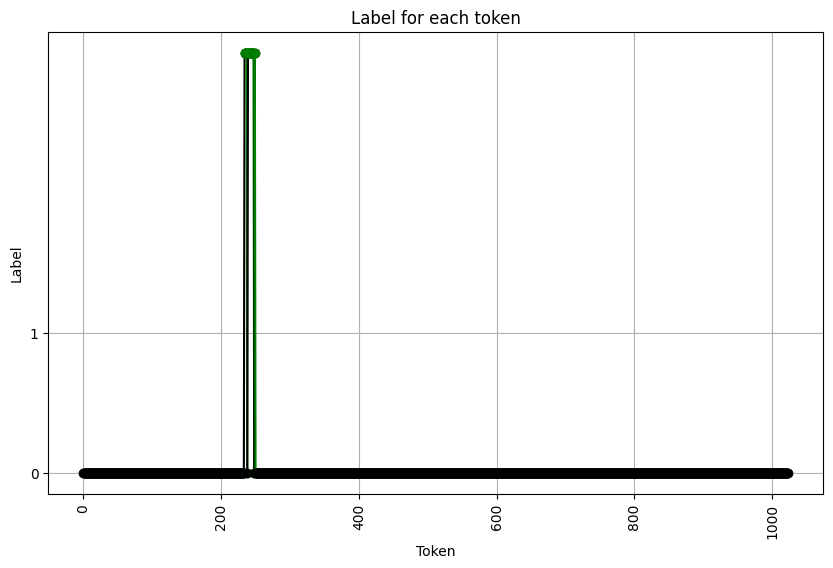

634it [05:33,  2.39it/s]

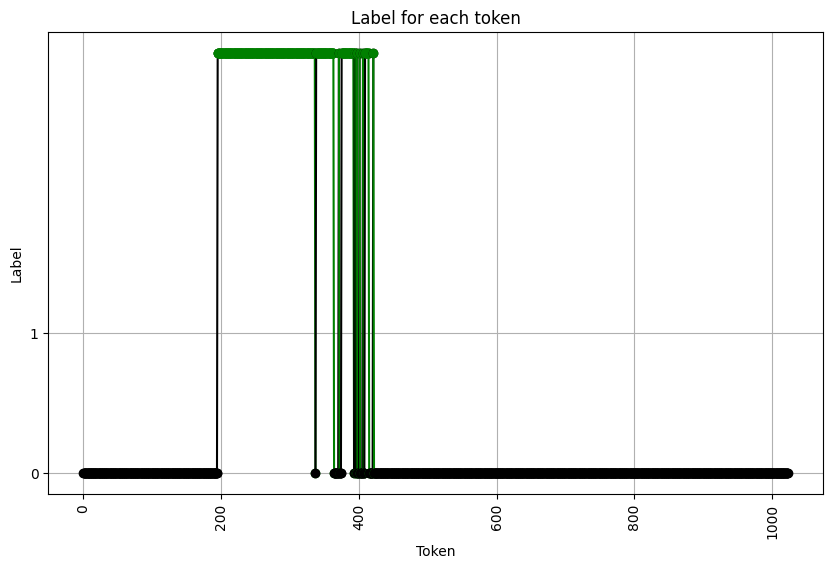

710it [06:10,  1.92it/s]


In [17]:
from Bio import SeqIO
from tqdm import tqdm 
from collections import Counter

predictions_anubis_return = []

for _,row in tqdm(DF_info_seek_TP.iterrows()) :
    prediction, sequence_outputs = predict_sequence(model_classifier, row["seq"])
    if prediction[0] == 1 :
        count_labels = dict(Counter(sequence_outputs))
        if 3 in count_labels and count_labels[3] >= 1 :
            plot_token(sequence_outputs)
            predictions_anubis_return.append((row["index"] , count_labels[3]))
        

In [18]:
predictions_anubis_return

[('anubis_return__372', 217),
 ('anubis_return__898', 277),
 ('anubis_return__1082', 344),
 ('anubis_return__1536', 190),
 ('anubis_return__1868', 70),
 ('anubis_return__1951', 153),
 ('anubis_return__2265', 279),
 ('anubis_return__2588', 217),
 ('anubis_return__2807', 7),
 ('anubis_return__2839', 67),
 ('anubis_return__2973', 21),
 ('anubis_return__3097', 200),
 ('anubis_return__3270', 14),
 ('anubis_return__3827', 199)]